# Which football team is more likely to win a match?

## Introduction

Capitalism, people’s passion for sports, and technology, enabled the development of a new economic market: sport bet sites. These sites allow you to gamble in an extensive bet types portfolio. In football, you can bet on the final result (Home win, Away win, Draw), final score, score difference, players who score, players who assist, number of corner kicks, number of yellow/red cards, players who will get a yellow/red card,  among others. Your profit depends on the betting odds: the lower your winning odds, the larger your reward.

In this work, we will apply Exploratory Data Analysis to the database collected and shared by Hugo Mathien on Kaggle: https://www.kaggle.com/hugomathien/soccer

This database is stored within a .sqlite file. It contains seven tables (Match, League, Country, Team, Team_Attributes, Player, Player_Attributes). All the tables include at least one Primary Key, so it’s feasible to join all of them. This piece of work will focus on the Match table. This table comprises data of matches played in eleven European Leagues and eight seasons. We will merge it with the other tables to obtain our final dataset.


In [1]:
import sqlite3 as sq3
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import missingno
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 120)

con = sq3.connect('C:/Users/spc_1/Documents/SPC/EDUCACION/MSC_DATA_SCIENCE/Courses/ST445_Managing_&_VisualizingData/Project/European_Soccer_Db/European_soccer_DB.sqlite')

In [2]:
mycur = con.cursor() 
mycur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
available_table = (mycur.fetchall())
available_table

[('Country',),
 ('League',),
 ('Match',),
 ('Player',),
 ('Player_Attributes',),
 ('Team',),
 ('Team_Attributes',),
 ('sqlite_sequence',)]

## Research question

Is there any pattern, supported with data, that enable the sport gambling investors to increase their winning odds?


## Data acquisition and initial validations

First of all, we will check if the 'Match' table contains the data of all the matches played each season by league. To do this, we will inspect the number of teams within each league by season, which should not vary among seasons. We will then compute the number of matches each league should hold, according to the number of teams. Finally, we will cross this outcome with the real data and examine if there are any differences.

In [3]:
# Number of teams per season
teams_qty = pd.io.sql.read_sql('SELECT DISTINCT lg.name as league_name, season, home_team_api_id as teams FROM Match as mt \
                            LEFT JOIN League as lg ON mt.league_id = lg.id',con)
teams_qty = teams_qty.pivot_table(index = ['league_name'], columns = 'season', aggfunc = 'size')
teams_qty

season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
league_name,,,,,,,,
Belgium Jupiler League,18,15,16,16,16,4,16,16
England Premier League,20,20,20,20,20,20,20,20
France Ligue 1,20,20,20,20,20,20,20,20
Germany 1. Bundesliga,18,18,18,18,18,18,18,18
Italy Serie A,20,20,20,20,20,20,20,20
Netherlands Eredivisie,18,18,18,18,18,18,18,18
Poland Ekstraklasa,16,16,16,16,16,16,16,16
Portugal Liga ZON Sagres,16,16,16,16,16,16,18,18
Scotland Premier League,12,12,12,12,12,12,12,12


Given that the 'Belgium Jupiler League' and the 'Portugal Liga ZON Sagres' have some variations amid seasons, we investigated what happened during these periods.

In [4]:
# Jupiler League, also known as Belgian Pro League
res = requests.get("https://en.wikipedia.org/wiki/Belgian_First_Division_A")
soup = BeautifulSoup(res.content,'lxml')
lists = soup.find_all('p')
ls = []
for li in lists:
    ls.append(li.text.split(' \u2013 '))
s = ls[11][0].split('.')
'.'.join(s[:2])

'Starting with the 2009–10 season, the format of the Pro League has been drastically changed. Playoffs were introduced after the regular season, the number of teams was decreased from 18 to 16 and the calendar has also been modified, with matches being played during the Christmas holiday'

In [5]:
# Liga NOS, also known as the Primeira Liga
res = requests.get("https://en.wikipedia.org/wiki/Primeira_Liga")
soup = BeautifulSoup(res.content,'lxml')
lists = soup.find_all('p')
ls = []
for li in lists:
    ls.append(li.text.split(' \u2013 '))
ls[16][0]

'From the 2014–15 season on, there are 18 clubs in the Primeira Liga, up from 16 in the previous seasons. During the course of a season, each club plays all teams twice'

This is also known as a double round-robin basis.

In [6]:
# Round-robin definition
res = requests.get("https://en.wikipedia.org/wiki/Round-robin_tournament")
soup = BeautifulSoup(res.content,'lxml')
lists = soup.find_all('p')
ls = []
for li in lists:
    ls.append(li.text.split('.'))
ls[2][0]

'A round-robin tournament (or all-play-all tournament) is a competition in which each contestant meets all other contestants in turn'

We will use this concept later.

Now we can conclude that the Portugal Liga ZON Sagres data is correct, and the Belgium Jupiler League has missing data, one team in the '2009/2010' season, and twelve teams on the '2013/2014' season.

### How many matches (rows) should have the different leagues each season?
Number of matches (match_qty) = (Number of teams - 1) x (Number of round-robins) x (Number of teams/2).

Each team plays against all the teams (Number of teams - 1) for n times (Number of round-robins). Each match is played by two teams (Number of teams/2)

In [7]:
teams_qty['2009/2010'][0] = 16
teams_qty['2013/2014'][0] = 16
teams_qty_mat = teams_qty.to_numpy().T

In [8]:
league = pd.io.sql.read_sql('SELECT id, name FROM League', con)
league['Round_robins'] = [2, 2, 2, 2, 2, 2, 2, 2, 38/11, 2, 4]
round_robins = league['Round_robins'].to_numpy()
league

,id,name,Round_robins
0,1,Belgium Jupiler League,2.000000
1,1729,England Premier League,2.000000
2,4769,France Ligue 1,2.000000
3,7809,Germany 1. Bundesliga,2.000000
4,10257,Italy Serie A,2.000000
5,13274,Netherlands Eredivisie,2.000000
6,15722,Poland Ekstraklasa,2.000000
7,17642,Portugal Liga ZON Sagres,2.000000
8,19694,Scotland Premier League,3.454545
9,21518,Spain LIGA BBVA,2.000000


In [9]:
match_calc_mat = (((teams_qty_mat - 1) * round_robins) * (teams_qty_mat/2)).T
match_calc = pd.io.sql.read_sql('SELECT name as League FROM League', con)
match_calc = pd.concat([match_calc, pd.DataFrame(match_calc_mat, columns = teams_qty.columns)], axis = 1)
match_calc = match_calc.set_index('League')
match_calc

,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
League,,,,,,,,
Belgium Jupiler League,306.0,240.0,240.0,240.0,240.0,240.0,240.0,240.0
England Premier League,380.0,380.0,380.0,380.0,380.0,380.0,380.0,380.0
France Ligue 1,380.0,380.0,380.0,380.0,380.0,380.0,380.0,380.0
Germany 1. Bundesliga,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0
Italy Serie A,380.0,380.0,380.0,380.0,380.0,380.0,380.0,380.0
Netherlands Eredivisie,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0
Poland Ekstraklasa,240.0,240.0,240.0,240.0,240.0,240.0,240.0,240.0
Portugal Liga ZON Sagres,240.0,240.0,240.0,240.0,240.0,240.0,306.0,306.0
Scotland Premier League,228.0,228.0,228.0,228.0,228.0,228.0,228.0,228.0


### How many matches (rows) does the 'Match' table contains from the different leagues each season?

In [10]:
match_qty = pd.io.sql.read_sql('SELECT lg.name as league_name, season, home_team_api_id teams FROM Match as mt \
                            LEFT JOIN League as lg ON mt.league_id = lg.id',con)
match_qty = match_qty.pivot_table(index = 'league_name', columns = 'season', aggfunc = 'size')
match_qty_mat = match_qty.to_numpy()
match_qty

season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
league_name,,,,,,,,
Belgium Jupiler League,306,210,240,240,240,12,240,240
England Premier League,380,380,380,380,380,380,380,380
France Ligue 1,380,380,380,380,380,380,380,380
Germany 1. Bundesliga,306,306,306,306,306,306,306,306
Italy Serie A,380,380,380,358,380,380,379,380
Netherlands Eredivisie,306,306,306,306,306,306,306,306
Poland Ekstraklasa,240,240,240,240,240,240,240,240
Portugal Liga ZON Sagres,240,240,240,240,240,240,306,306
Scotland Premier League,228,228,228,228,228,228,228,228


### Which league has missing data (matches)?

In [11]:
missing = pd.io.sql.read_sql('SELECT name as League FROM League', con)
missing = pd.concat([missing, pd.DataFrame(match_qty_mat - match_calc_mat, columns = teams_qty.columns)], axis = 1)
missing = missing.set_index('League')
missing = missing[(missing < 0).any(axis = 1)]
missing

,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
League,,,,,,,,
Belgium Jupiler League,0.0,-30.0,0.0,0.0,0.0,-228.0,0.0,0.0
Italy Serie A,0.0,0.0,0.0,-22.0,0.0,0.0,-1.0,0.0
Switzerland Super League,0.0,0.0,0.0,-18.0,0.0,0.0,0.0,0.0


In [12]:
matches = pd.io.sql.read_sql('SELECT * FROM Match',con)
missing_perc = round(abs(sum(missing.sum(axis = 1)))/matches.shape[0]*100, 2)
print('The "Match" table lacks', str(missing_perc) + '%', 'of the matches information.', '\n')
print('The leagues with missing data are:', '\n', missing.sum(axis = 1))

The "Match" table lacks 1.15% of the matches information. 

The leagues with missing data are: 
 League
Belgium Jupiler League     -258.0
Italy Serie A               -23.0
Switzerland Super League    -18.0
dtype: float64


## Data Cleaning and Shaping

In [13]:
print('The Match table has', matches.shape[0], 'rows, and', matches.shape[1], 'columns.')
print('We decided to exclude the position variables (home_player_Xi, away_player_Xi, home_player_Yi, away_player_Yi, \
where i = 1, 2, … 11) and all but Bet365, Bet&Win and Interwetten bet sites (as the bet odds tend to have a strong \
correlation coefficient among bet sites).')

The Match table has 25979 rows, and 115 columns.
We decided to exclude the position variables (home_player_Xi, away_player_Xi, home_player_Yi, away_player_Yi, where i = 1, 2, … 11) and all but Bet365, Bet&Win and Interwetten bet sites (as the bet odds tend to have a strong correlation coefficient among bet sites).


In [14]:
matches = pd.concat([matches.iloc[:, 2:11], matches.iloc[:, 55:77],matches.iloc[:, 85:94]], axis = 1)
matches.head(3)

,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA
0,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.73,3.4,5.00,1.75,3.35,4.20,1.85,3.2,3.5
1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.95,3.2,3.60,1.80,3.30,3.95,1.90,3.2,3.5
2,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.38,3.3,2.75,2.40,3.30,2.55,2.60,3.1,2.3


In [15]:
home_players = list(matches.iloc[:, 9:20].columns)
away_players = list(matches.iloc[:, 20:31].columns)
all_players = list(matches.iloc[:, 9:31].columns)
print(home_players[:3], away_players[:3])

['home_player_1', 'home_player_2', 'home_player_3'] ['away_player_1', 'away_player_2', 'away_player_3']


Now we will create a table with the players attributes, where each row contains data about one unique player (no duplicates). The 'Player' table includes the height and weight, with one observation per player. The 'Player_Attributes' has more than one observation per player, because it was updated every time FIFA released these attributes in the video game. For simplicity, we will use the most recents features.

In [16]:
player_atts = pd.io.sql.read_sql('SELECT at.*, height, weight FROM Player pl INNER JOIN \
                   (SELECT pa.player_api_id, pa.finishing, pa.shot_power, pa.heading_accuracy, pa.short_passing, \
                   pa.long_passing, pa.dribbling, pa.marking, pa.sprint_speed, pa.strength FROM \
                   (SELECT MAX(date) as date, player_api_id FROM Player_Attributes \
                    WHERE player_api_id NOT IN(41308, 110189, 178196, 193866) \
                    GROUP BY player_api_id) as id \
                   LEFT JOIN Player_Attributes as pa ON id.player_api_id = pa.player_api_id and id.date = pa.date) as at \
                   ON pl.player_api_id = at.player_api_id', con)

Since the 'Match' table includes the id of the 22 initial players on each match, we will create a function that obtains their attributes, computes the average for the Home and the Away team, and leaves only these last columns. 

In [17]:
def attribute_average(team_players, matches, players_attributes, home_away):
    for player in team_players:
        matches = matches.merge(players_attributes, left_on = player, right_on = 'player_api_id', how = 'left')
        matches = matches.rename(columns = {matches.columns[-1] : str(matches.columns[-1] + '_'  + player)})
        matches = matches.drop([matches.columns[-2]], axis = 1)

    matches[str(players_attributes.columns[1] + '_' + home_away + 'team' + '_mean')] = matches.iloc[:, -11:].mean(1)
    matches = matches.drop(list(matches.iloc[:, -12:-1].columns), axis = 1)
    return matches

In [18]:
for column_i in range(1, player_atts.shape[1]):
    matches = attribute_average(home_players, matches, 
                                pd.concat([player_atts['player_api_id'], player_atts.iloc[:, column_i]], axis = 1), 'home')
    
    matches = attribute_average(away_players, matches, 
                                pd.concat([player_atts['player_api_id'], player_atts.iloc[:, column_i]], axis = 1), 'away')

matches = matches.drop(['stage', 'date'], axis = 1)
matches = matches.drop(all_players, axis = 1)

Now we create a column with the total goals on each match.

In [19]:
matches = matches.merge(league[['id', 'name']], left_on = 'league_id', right_on = 'id', how = 'left')
matches = matches.drop(['id', 'league_id'], axis = 1)
matches = matches.rename(columns = {'name' : 'League'})
matches['Total_goals'] = matches[['home_team_goal', 'away_team_goal']].sum(1)

In [20]:
missing_values = round(matches.isnull().sum()/len(matches)*100, 2)
print('Percentage of missing values', '\n', missing_values)

Percentage of missing values 
 season                             0.00
match_api_id                       0.00
home_team_api_id                   0.00
away_team_api_id                   0.00
home_team_goal                     0.00
away_team_goal                     0.00
B365H                             13.04
B365D                             13.04
B365A                             13.04
BWH                               13.10
BWD                               13.10
BWA                               13.10
IWH                               13.31
IWD                               13.31
IWA                               13.31
finishing_hometeam_mean            2.92
finishing_awayteam_mean            2.92
shot_power_hometeam_mean           2.92
shot_power_awayteam_mean           2.92
heading_accuracy_hometeam_mean     2.92
heading_accuracy_awayteam_mean     2.92
short_passing_hometeam_mean        2.92
short_passing_awayteam_mean        2.92
long_passing_hometeam_mean         2.92
long_pass

Given that we have some columns without missing values, we will make some EDA about these data.

In [21]:
# Main leagues
grouped_leagues = matches.groupby('League')
goals = grouped_leagues['Total_goals'].agg(['sum'])
goals
goals = goals.sort_values(by = ['sum'], ascending = False).head()
main_leagues = list(goals.index)

goals_by_league = matches.pivot_table(index = ['season'], columns = 'League', values = 'Total_goals', aggfunc = 'sum')
goals_by_league = goals_by_league[main_leagues]

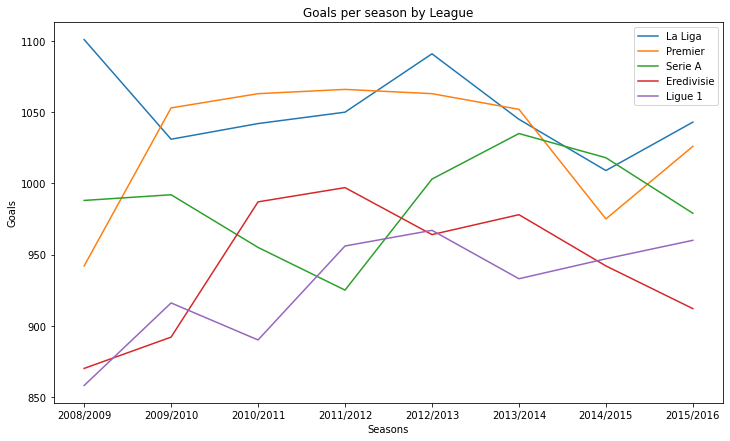

In [22]:
fig, ax = plt.subplots(figsize = (12, 7))

plt.plot(goals_by_league.index, goals_by_league['Spain LIGA BBVA'], label = 'La Liga')
plt.plot(goals_by_league.index, goals_by_league['England Premier League'], label = 'Premier')
plt.plot(goals_by_league.index, goals_by_league['Italy Serie A'], label = 'Serie A')
plt.plot(goals_by_league.index, goals_by_league['Netherlands Eredivisie'], label = 'Eredivisie')
plt.plot(goals_by_league.index, goals_by_league['France Ligue 1'], label = 'Ligue 1')

plt.legend()

plt.xlabel('Seasons')
plt.ylabel('Goals')
plt.title('Goals per season by League')

plt.show()

The five leagues with greater number of goals in the examined period are la Liga, Premier, Serie A, Eredvisie and Ligue 1. The above chart illustrates that la Liga and the Premier are the goal leaders. It doesn't seems to be any pattern among each season.

Now we will identify which are the most frequent scores in each match. 

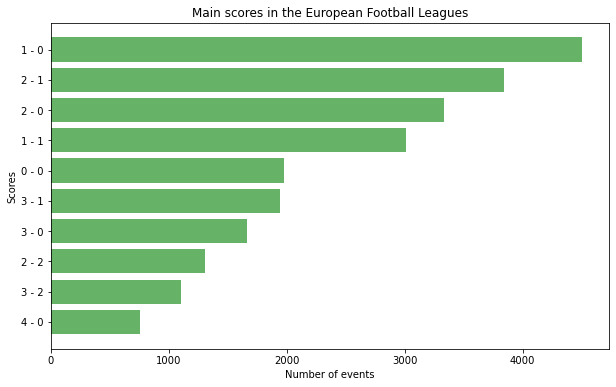

In [23]:
def score(matches):
    if matches['home_team_goal'] > matches['away_team_goal']:
        return str(matches['home_team_goal']) + ' - ' + str(matches['away_team_goal'])
    elif matches['home_team_goal'] < matches['away_team_goal']:
        return str(matches['away_team_goal']) + ' - ' + str(matches['home_team_goal'])
    else:
        return str(matches['away_team_goal']) + ' - ' + str(matches['home_team_goal'])

matches['Score'] = matches.apply(score, axis=1)

main_scores = matches.groupby('Score').size().sort_values(ascending = False)[:10]
main_scores = main_scores.sort_values(ascending = True)

plt.subplots(figsize = (10, 6))
plt.barh(main_scores.index, main_scores, alpha = 0.6, color = 'g')
plt.xlabel('Number of events')
plt.ylabel('Scores')
plt.title('Main scores in the European Football Leagues')
plt.show()

There were more than twenty possible results. Here we left almost half of them. The most frequent result is [1 - 0]. Surprisingly, [0 - 0] and [3 - 1] have almost the same probability. Investors bet a lot on [0 - 0] results, more than [3 - 1]

Now we will check which is the most likely winning team: Home, Away or draw.

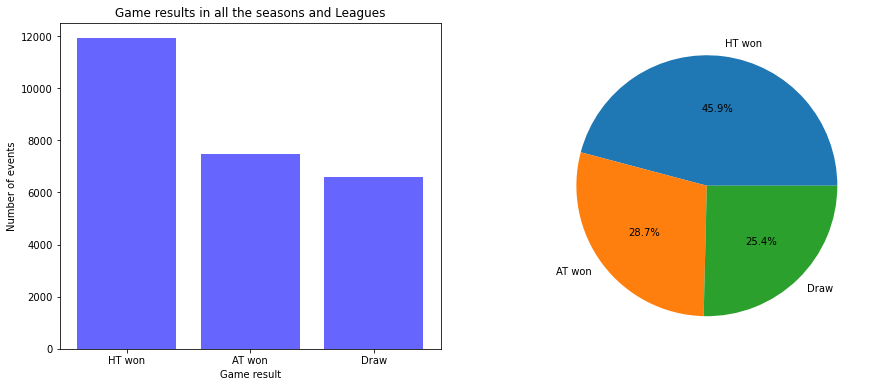

In [24]:
def result(matches):
    if matches['home_team_goal'] > matches['away_team_goal']:
        return 'HT won'
    elif matches['home_team_goal'] < matches['away_team_goal']:
        return 'AT won'
    else:
        return 'Draw'

matches['Result'] = matches.apply(result, axis=1)
results = matches.groupby('Result').size().sort_values(ascending = False)

fig, ax = plt.subplots(1, 2, figsize = (15, 6))
ax[0].bar(results.index, results, alpha = 0.6, color = 'b')
ax[0].set_ylabel('Number of events')
ax[0].set_xlabel('Game result')
ax[0].set_title('Game results in all the seasons and Leagues')

ax[1].pie(results, labels = results.index, autopct='%1.1f%%')
plt.show()

This plot gives one of the most important insights: The Home team has a probability of 46% of winning a match. The away team has a 29%, and a draw has a 25% probability.

In [25]:
avg_goals_HTwon = matches[matches['Result'] == 'HT won']['home_team_goal'].sum()/len(matches[matches['Result'] == 'HT won'])
avg_goals_ATwon = matches[matches['Result'] == 'AT won']['away_team_goal'].sum()/len(matches[matches['Result'] == 'AT won'])
print('The average number of goals per match of the Home team when it wins is', round(avg_goals_HTwon, 2))
print('The average number of goals per match of the Away team when it wins is', round(avg_goals_ATwon, 2))

The average number of goals per match of the Home team when it wins is 2.44
The average number of goals per match of the Away team when it wins is 2.3


<AxesSubplot:xlabel='away_team_goal', ylabel='Density'>

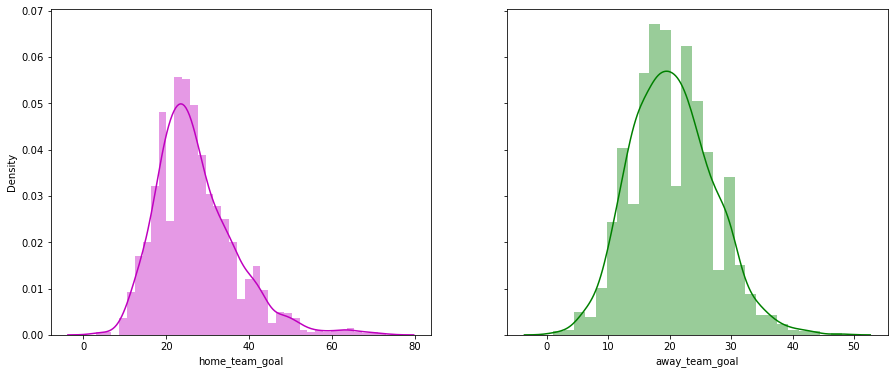

In [26]:
goals_by_team = matches.groupby(['season', 'home_team_api_id']).aggregate({'home_team_goal':'sum', 'away_team_goal':'sum'})

warnings.filterwarnings('ignore')
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 6), sharey=True)
sns.distplot(goals_by_team['home_team_goal'], color="m", ax = ax1)
sns.distplot(goals_by_team['away_team_goal'], color="g", ax = ax2)

The home team and the away team tends to score the same amount of goals by season. The main difference is the heavy tails of home team goals distribution. 

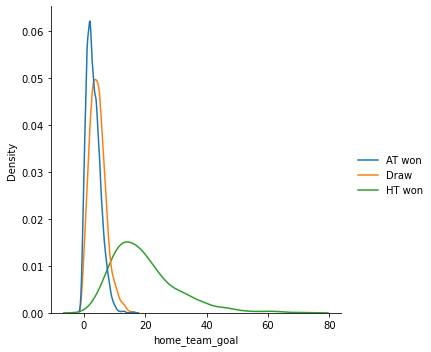

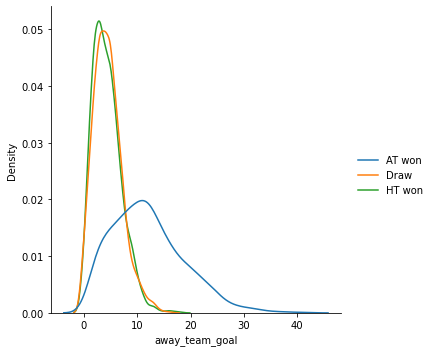

In [27]:
goals_by_team2 = matches.groupby(['season', 'home_team_api_id', 'Result']).aggregate({'home_team_goal':'sum', 'away_team_goal':'sum'})

result_ls = []
for i in goals_by_team2.index:
    result_ls.append(i[2])

sns.displot(goals_by_team2, x = 'home_team_goal', hue= result_ls, kind="kde")
sns.displot(goals_by_team2, x = 'away_team_goal', hue= result_ls, kind="kde")

In the same line of the previews comment, the distribution of the winning team has larger tails

The following plot gives a general view of the missing values across all the dataset. Is very useful to detect if removing an observation will remove non-missing data.

<AxesSubplot:>

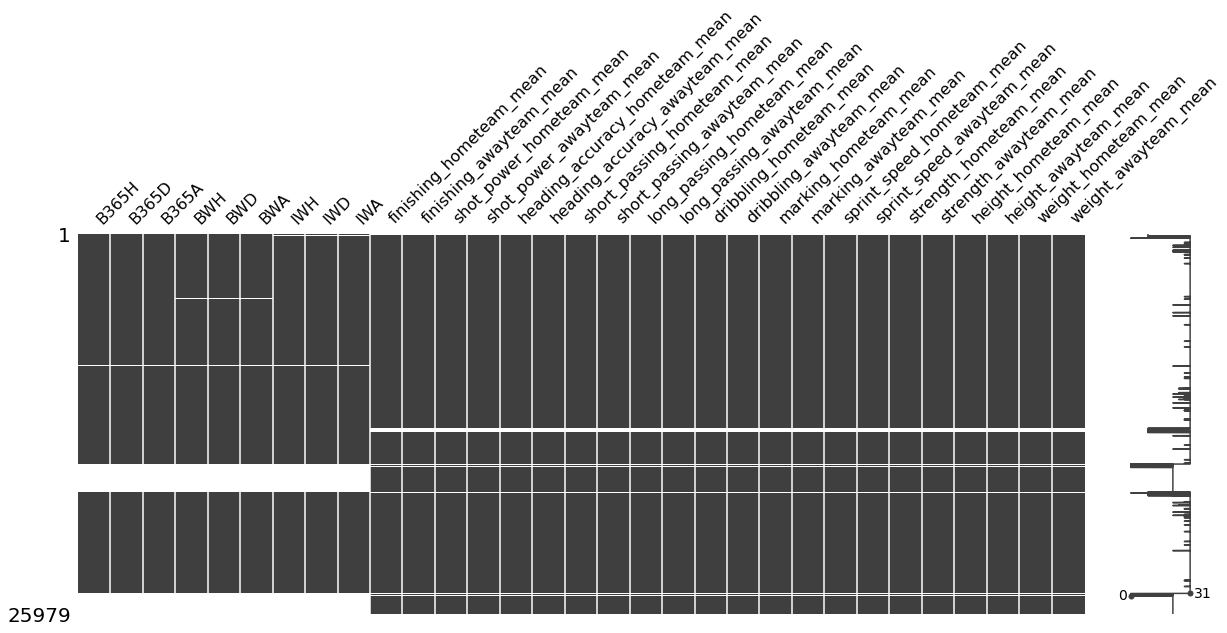

In [28]:
nan_counts = matches.isna().sum()
nan_columnnames = nan_counts.loc[nan_counts > 0].index
missingno.matrix(matches[nan_columnnames], figsize=(20,7))

In these case, we can remove missing values, given that there are not too many, and almost all the columns have the same missing observations.

In [29]:
matches = matches.dropna(axis=0)

In [30]:
matches = matches.reset_index()
matches = matches.drop(['index'], axis = 1)

Finally, we will analyze the main attributes of the offensive (finishing), middle (dribbling) and defensive (marking) line.

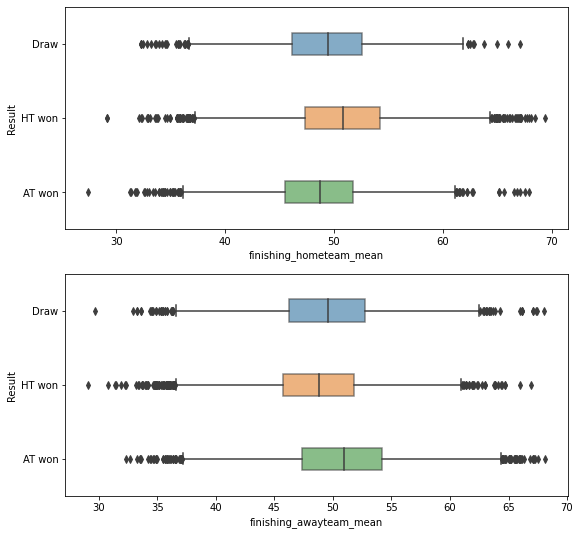

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (9, 9))
sns.boxplot(data = matches, x = 'finishing_hometeam_mean', y = 'Result', width = 0.3, boxprops = dict(alpha=0.6), ax = ax1) 
sns.boxplot(data = matches, x = 'finishing_awayteam_mean', y = 'Result', width = 0.3, boxprops = dict(alpha=0.6), ax = ax2) 
plt.show()

The winning team (Home or Away) has on average, a better finishing performance than the losing team.

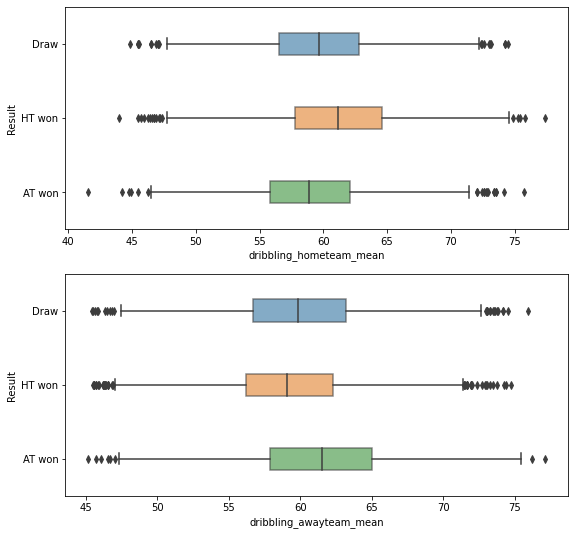

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (9, 9))
sns.boxplot(data = matches, x = 'dribbling_hometeam_mean', y = 'Result', width = 0.3, boxprops = dict(alpha=0.6), ax = ax1) 
sns.boxplot(data = matches, x = 'dribbling_awayteam_mean', y = 'Result', width = 0.3, boxprops = dict(alpha=0.6), ax = ax2) 
plt.show()

Similarly, the winning team (Home or Away) has on average, a better dribbiling performance than the losing team.

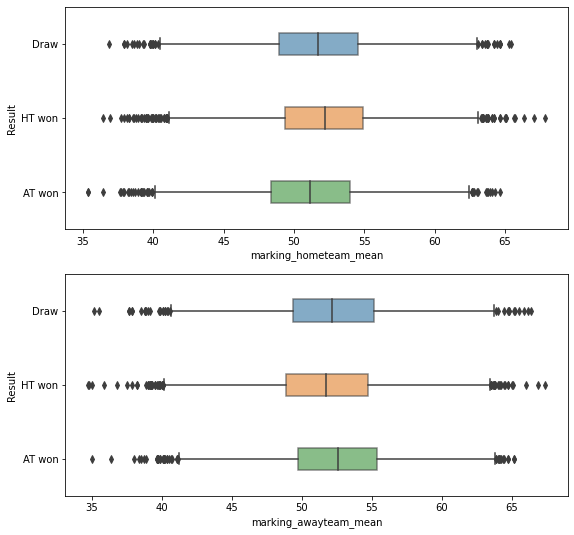

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (9, 9))
sns.boxplot(data = matches, x = 'marking_hometeam_mean', y = 'Result', width = 0.3, boxprops = dict(alpha=0.6), ax = ax1) 
sns.boxplot(data = matches, x = 'marking_awayteam_mean', y = 'Result', width = 0.3, boxprops = dict(alpha=0.6), ax = ax2) 
plt.show()

Although the differences between the winning and losing teams are little, the same conclusion stands: the winning team (Home or Away) has on average, a better marking performance than the losing team.

## Conclusions

Despite this work just analyzes some features, we achieved interesting insights that may help sport gambling investors. We identified that FIFA's attributes like finishing, dribbling and marking help to determine which can be a winning team. We also identified that the most frequent score is [1-0], and the most likely team to win is the home-team. An investor might use these exploratory data analysis to support its investments. For example, I will prefer to invest on a Draw, if the Away team have slightly better attributes than the Home team. 

I am not a gambling person, but a big football fan, and surely there are lots of people like me. However, I enjoy working with data, and this kind of work may encourage people to make their first bets (investments). Of course this is not the stock market, but there must be ways to measure the risk.

There is plenty further work to do. But this is a start.
